# This sample code is used to test the clustering effect of STAIG on slice #151673 under the condition of having images.

### Step 0：Since Jupyter Notebook does not automatically release GPU memory after running, please run this code to clear all processes occupying GPU memory before the FIRST time starting execution.

In [1]:
!fuser -v /dev/nvidia* |awk '{for(i=1;i<=NF;i++)print "kill -9 " $i;}' | sh

                     USER        PID ACCESS COMMAND
/dev/nvidia-uvm:     root      mount /dev/nvidia-uvm
/dev/nvidia-uvm-tools:
                     root      mount /dev/nvidia-uvm-tools
/dev/nvidia0:        root      mount /dev/nvidia0
/dev/nvidiactl:      root      mount /dev/nvidiactl
sh: 1: kill: Illegal number: kernelkernelkernelkernel


### Step 1: Load packages

In [2]:
import argparse
import os
os.chdir('/remote-home/13186919777/home/STAIG-test')
import warnings
warnings.filterwarnings('ignore')
import random
import yaml
from yaml import SafeLoader
import torch
from staig.adata_processing import LoadSingle10xAdata,LoadBatch10xAdata
import numpy as np
from staig.staig import STAIG
import pandas as pd
import scanpy as sc

### Step 2: Load data and train

In [3]:

file_fold = './Dataset'


args = argparse.Namespace(
    dataset='DLPFC',
    slide='151673',
    config='train_img_config.yaml',
    label=True,
)

config = yaml.load(open(args.config), Loader=SafeLoader)[int(args.slide)]


slide_path = os.path.join(file_fold, args.dataset, args.slide)

torch.manual_seed(config['seed'])
np.random.seed(config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed(config['seed'])
    torch.cuda.manual_seed_all(config['seed'])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
random.seed(12345)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8' 
torch.use_deterministic_algorithms(True)
data = LoadSingle10xAdata(path=slide_path,n_neighbors=config['num_neigh'],n_top_genes=config['num_gene'],image_emb=True, label = args.label).run()
staig = STAIG(args=args,config=config,single=False)    
staig.adata = data
staig.train()
staig.eva()


Calculating edge_probabilities: 100%|██████████| 3611/3611 [00:00<00:00, 28782.32it/s]


adata load done
=== prepare for training ===
=== train ===


100%|██████████| [01:05<00:00,  4.56it/s]

=== load ===
[[ 0.28567921  0.9514627  -0.58912379 ... -0.93671922  0.25152384
  -0.13477519]
 [ 0.79713268 -1.28493085 -2.32117614 ...  1.3791495  -0.47870488
   0.07494548]
 [ 0.76633456 -3.99123656 -2.48387084 ...  3.78104504 -0.85405131
   0.18855374]
 ...
 [ 0.15872933 -2.14672616 -0.58743164 ...  2.0495322  -0.34117785
   0.16563115]
 [ 0.48271579 -2.87747501 -1.54134398 ...  2.62670397 -0.67122833
   0.16937761]
 [ 1.25869605  0.23974136 -3.109453   ...  0.09947682 -0.29321024
  -0.21220997]]
embedding generated, go clustering


### Step 3: Show results

fitting ...
  |======================================================================| 100%
calculate metric ARI
ARI: 0.6863942229614929
NMI: 0.7305887049375316


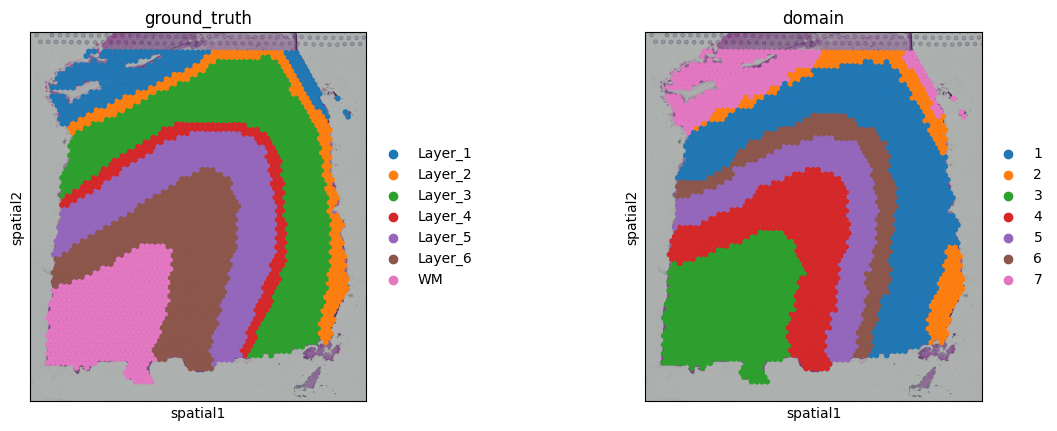

In [4]:
staig.cluster(args.label)
staig.draw_spatial()